# NumPyro with Pathfinder

In this notebook we describe how to use [`blackjax`](https://blackjax-devs.github.io/blackjax/index.html)'s [`pathfinder`](https://blackjax-devs.github.io/sampling-book/algorithms/pathfinder.html) implementation to do inference with  a [`numpyro`](https://num.pyro.ai/en/stable/) model.

I am simply putting some pieces together from the following resources (strongly recommended to read):

**References:**

- Blackjax docs: [Use with Numpyro models](https://blackjax-devs.github.io/blackjax/examples/howto_use_numpyro.html)
- Blackjax Sampling Book: [Pathfinder](https://blackjax-devs.github.io/sampling-book/algorithms/pathfinder.html)
- Numpyro Issue [#1485](https://github.com/pyro-ppl/numpyro/issues/1485)
- [PyMC Experimental - Pathfinder](https://github.com/pymc-devs/pymc-experimental/blob/main/pymc_experimental/inference/pathfinder.py)
- [Pathfinder: Parallel quasi-Newton variational inference](https://arxiv.org/abs/2108.03782)

### What and Why Pathfinder?

From the [paper](https://arxiv.org/abs/2108.03782)'s abstract:

- **What?**

> We propose Pathfinder, a variational method for approximately sampling from differentiable log densities. Starting from a random initialization, Pathfinder locates normal approximations to the target density along a quasi-Newton optimization path, with local covariance estimated using the inverse Hessian estimates produced by the optimizer. Pathfinder returns draws from the approximation with the lowest estimated Kullback-Leibler (KL) divergence to the true posterior. 

- **Why?**

> Compared to ADVI and short dynamic HMC runs, Pathfinder requires one to two orders of magnitude fewer log density and gradient evaluations, with greater reductions for more challenging posteriors.

## Prepare Notebook

In [1]:
import arviz as az
import blackjax
import jax
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist

from jax import random
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoMultivariateNormal
from numpyro.infer.util import initialize_model, Predictive


az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Generate Data

We generate some data from a simple linear regression model.

[Text(0.5, 0, 'x'), Text(0, 0.5, 'y'), Text(0.5, 1.0, 'Raw Data')]

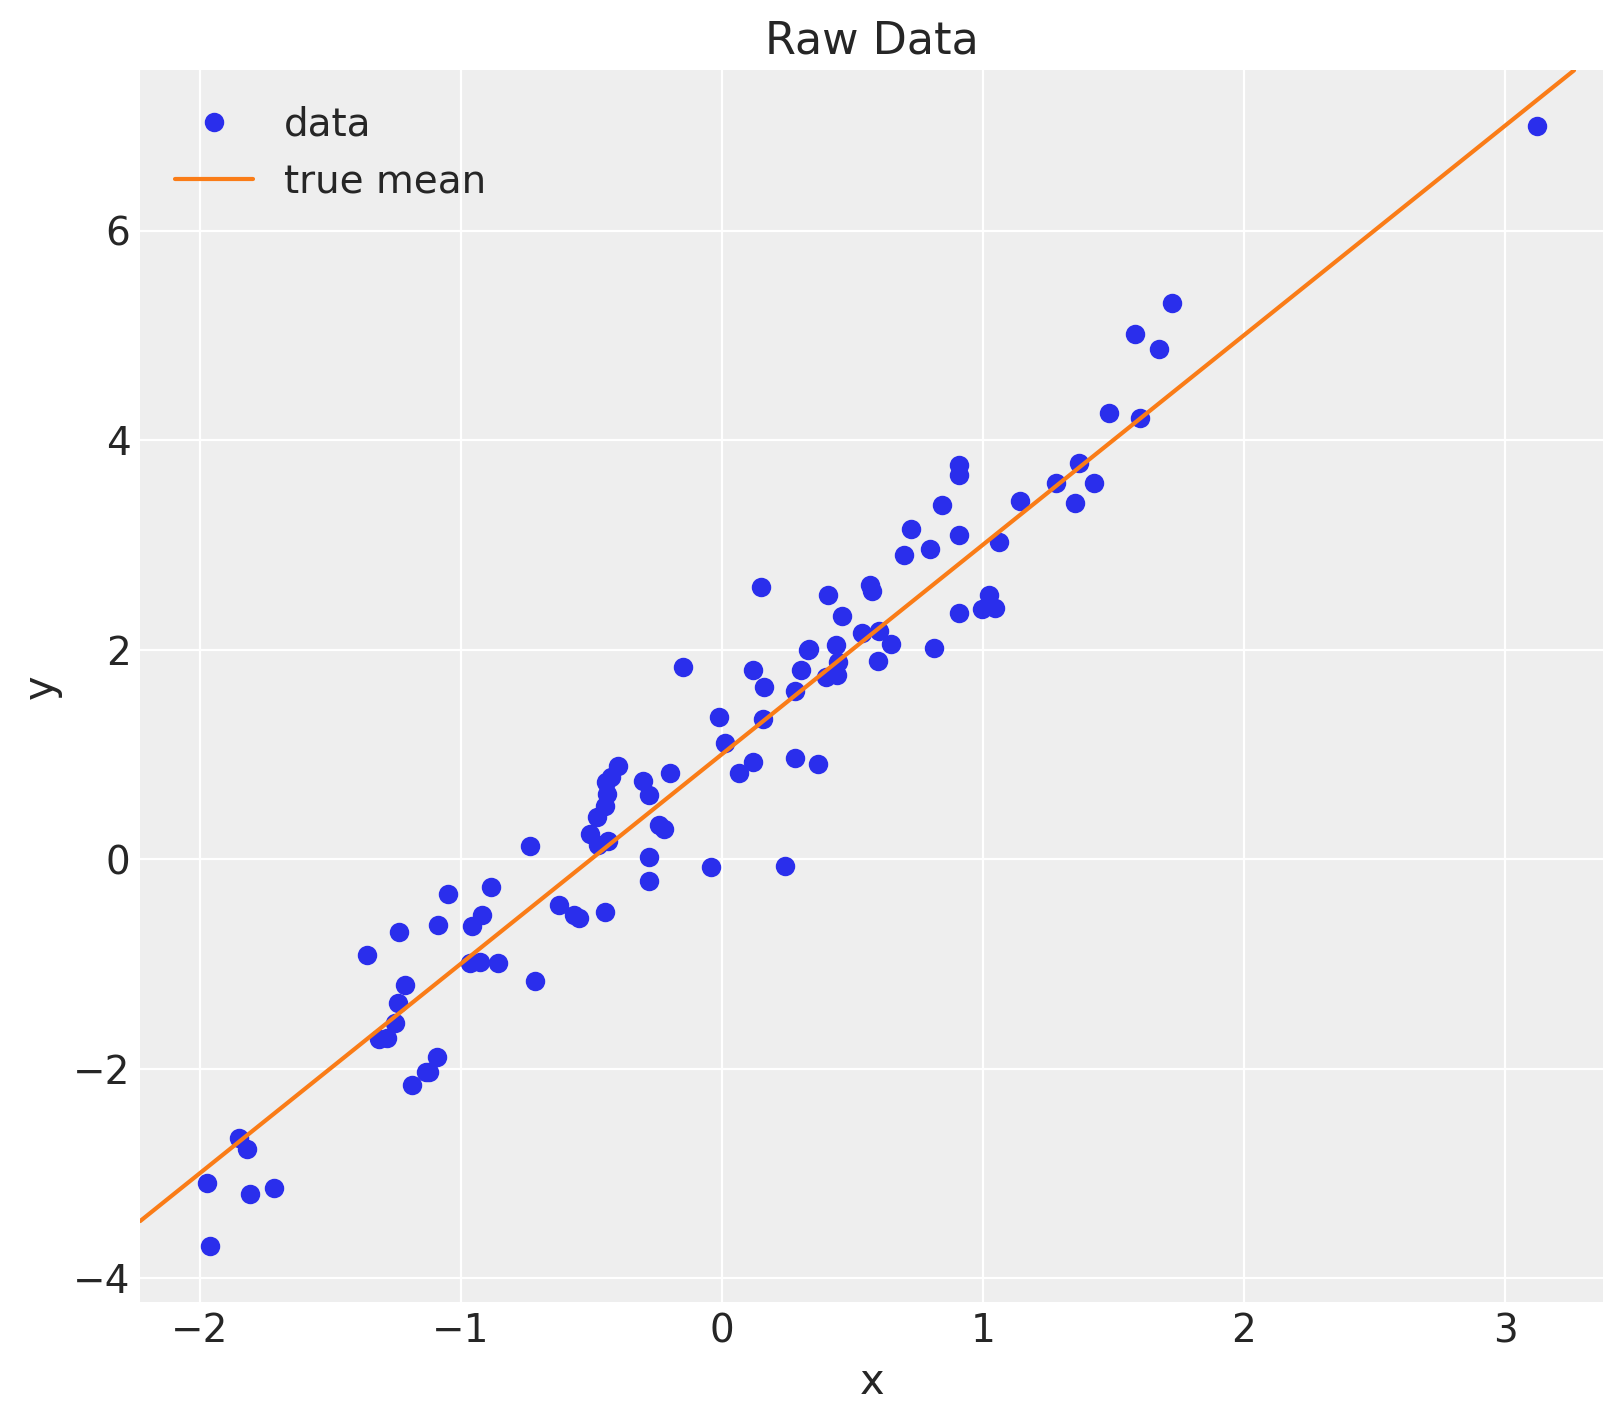

In [2]:
def generate_data(rng_key, a, b, sigma, n):
    x = random.normal(rng_key, (n,))
    rng_key, rng_subkey = random.split(rng_key)
    epsilon = sigma * random.normal(rng_subkey, (n,))
    y = a + b * x + epsilon
    return x, y


# true parameters
a = 1.0
b = 2.0
sigma = 0.5
n = 100

# generate data
rng_key, rng_subkey = random.split(rng_key)
x, y = generate_data(rng_key, a, b, sigma, n)

# plot data
fig, ax = plt.subplots(figsize=(8, 7))
ax.plot(x, y, "o", c="C0", label="data")
ax.axline((0, a), slope=b, color="C1", label="true mean")
ax.legend(loc="upper left")
ax.set(xlabel="x", ylabel="y", title="Raw Data")

## Model Specification

We define a simple linear regression model in `numpyro`.

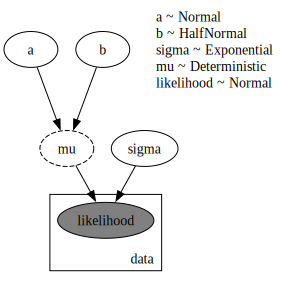

In [3]:
def model(x, y=None):
    a = numpyro.sample("a", dist.Normal(0.0, 2.0))
    b = numpyro.sample("b", dist.HalfNormal(2.0))
    sigma = numpyro.sample("sigma", dist.Exponential(1.0))
    mean = numpyro.deterministic("mu", a + b * x)
    with numpyro.plate("data", len(x)):
        numpyro.sample("likelihood", dist.Normal(mean, sigma), obs=y)


numpyro.render_model(
    model=model,
    model_args=(x, y),
    render_distributions=True,
    render_params=True,
)

## Pathfinder Sampler

The key function is [`initialize_model`](https://num.pyro.ai/en/stable/mcmc.html#numpyro.infer.util.initialize_model) from `numpyro`. This allow us to compute the log-density, which is required by `blackjax`'s `pathfinder` implementation. In addition, we get a way to transform the unconstrained space (where the optimization happens) to the constrained space.

In [4]:
rng_key, rng_subkey = random.split(rng_key)
param_info, potential_fn, postprocess_fn, *_ = initialize_model(
    rng_subkey,
    model,
    model_args=(x, y),
    dynamic_args=True,  # <- this is important!
)


# get log-density from the potential function
def logdensity_fn(position):
    func = potential_fn(x, y)
    return -func(position)


# get initial position
initial_position = param_info.z

We can now use [`blackjax.vi.pathfinder.approximate`](https://blackjax-devs.github.io/blackjax/autoapi/blackjax/vi/pathfinder/index.html#blackjax.vi.pathfinder.approximate) to run the variational inference algorithm.

In [5]:
# run pathfinder
rng_key, rng_subkey = random.split(rng_key)
pathfinder_state, _ = blackjax.vi.pathfinder.approximate(
    rng_key=rng_subkey,
    logdensity_fn=logdensity_fn,
    initial_position=initial_position,
    # num_samples=20_000,
    ftol=1e-4,
)

# sample from the posterior
rng_key, rng_subkey = random.split(rng_key)
posterior_samples, _ = blackjax.vi.pathfinder.sample(
    rng_key=rng_subkey,
    state=pathfinder_state,
    num_samples=5_000,
)

# convert to arviz
idata_pathfinder = az.from_dict(
    posterior={
        k: np.expand_dims(a=np.asarray(v), axis=0) for k, v in posterior_samples.items()
    },
)

## Visualize Results

In [6]:
az.summary(data=idata_pathfinder, round_to=3)

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.043,0.051,0.951,1.139,0.001,0.001,5047.694,4780.373,NaN
b,0.730,0.028,0.679,0.785,0.000,0.000,4998.218,4873.062,NaN
sigma,-0.657,0.069,-0.785,-0.527,0.001,0.001,5056.785,5101.670,NaN


Text(0.5, 0.98, 'Pathfinder Trace - Transformed Space')

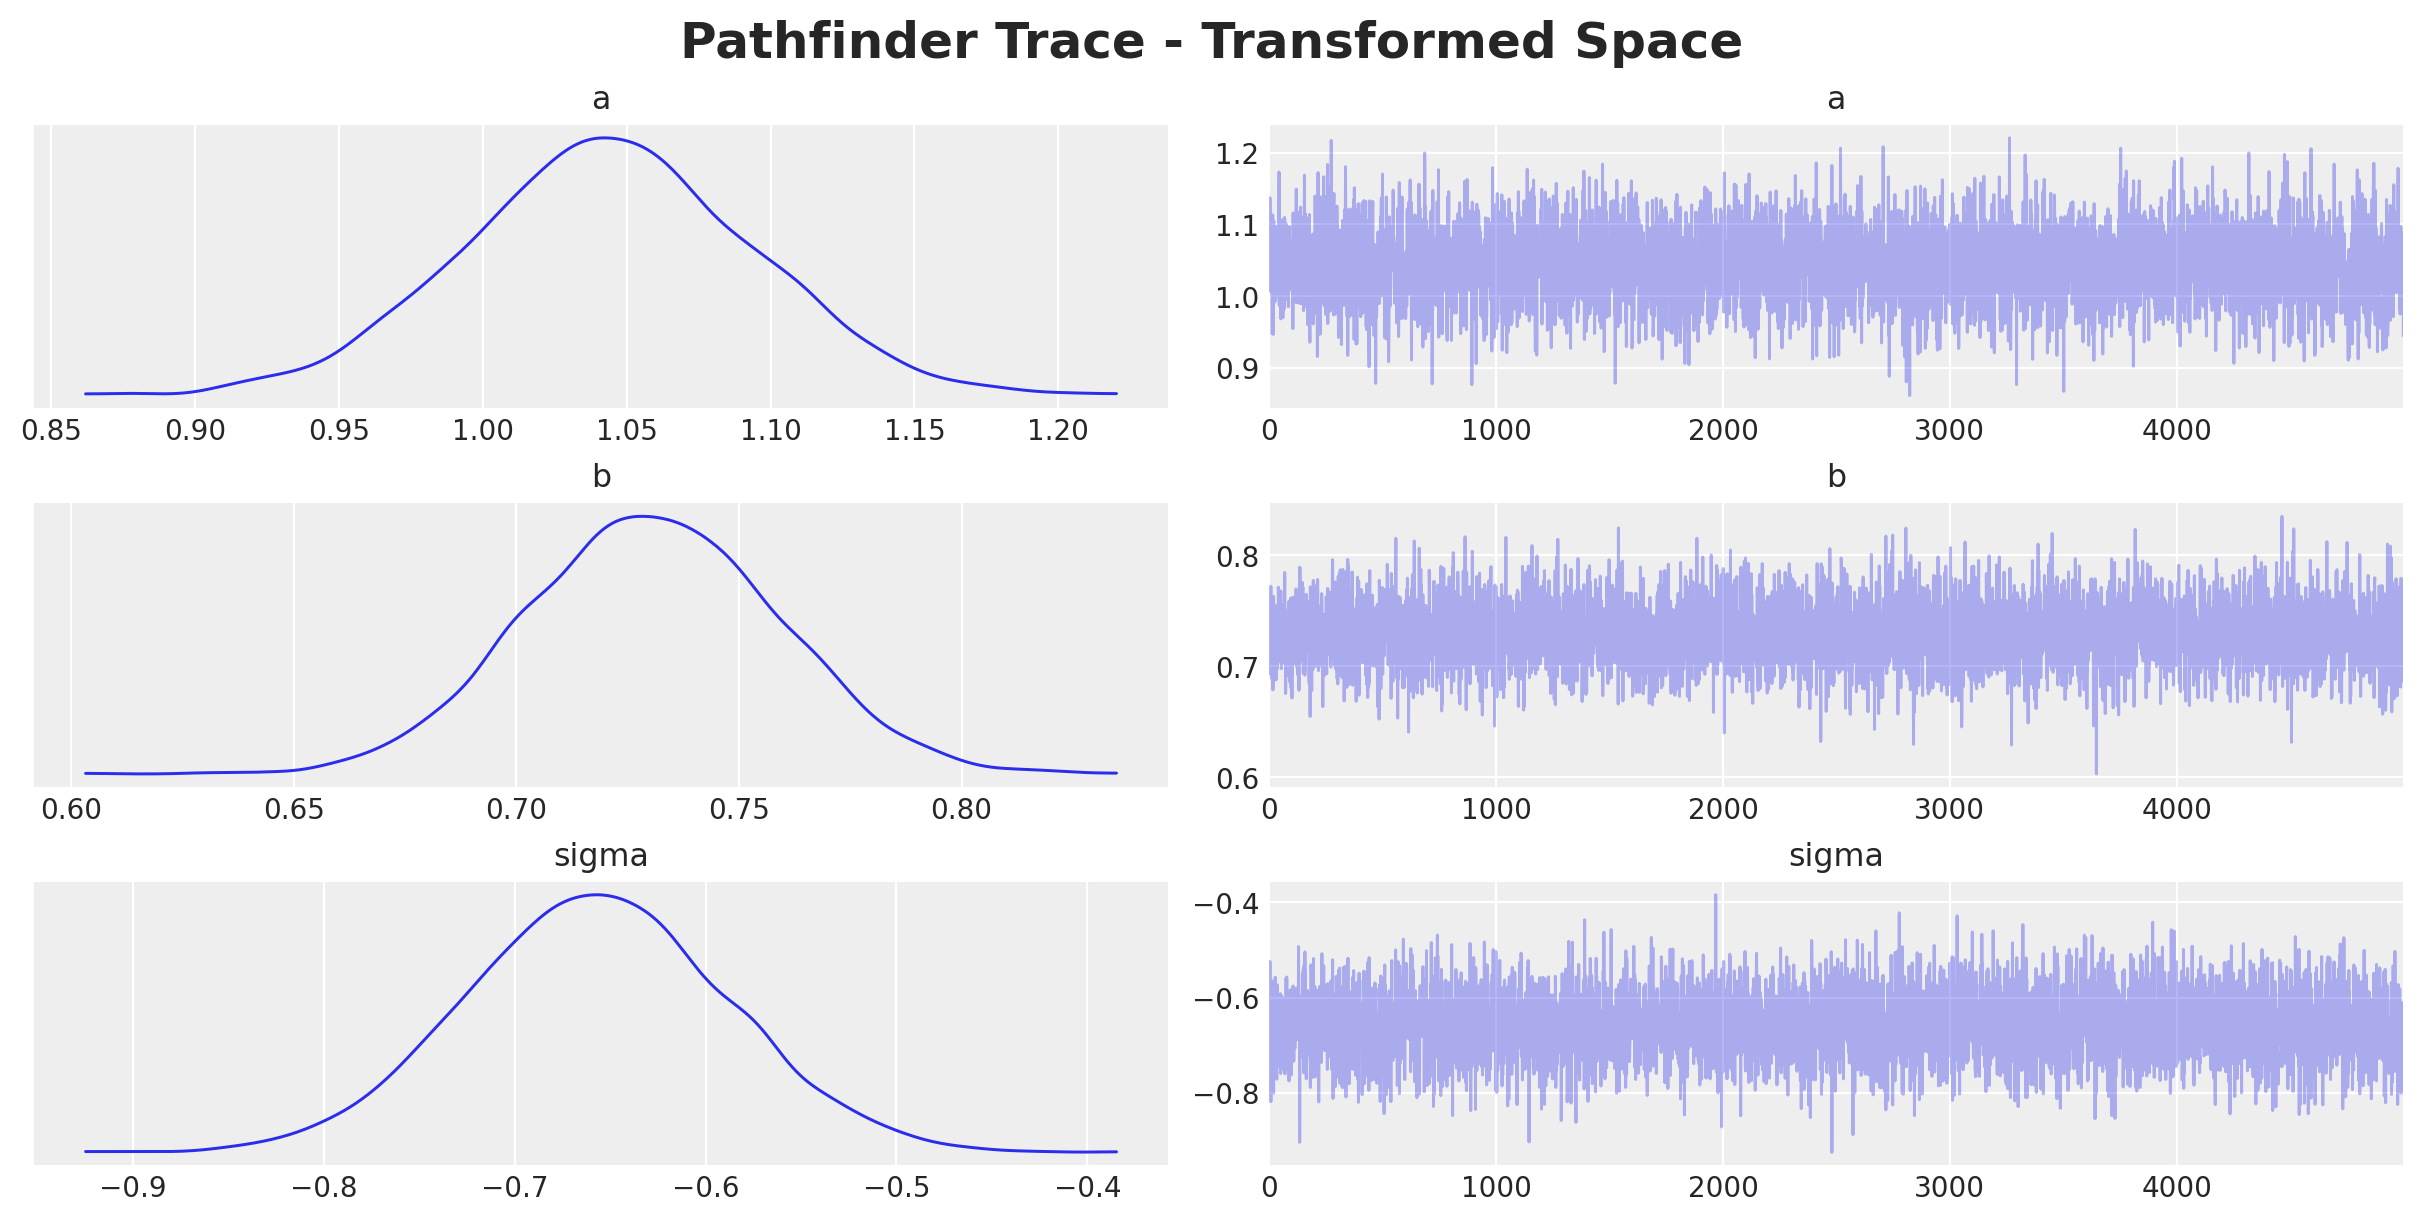

In [7]:
axes = az.plot_trace(
    data=idata_pathfinder,
    compact=True,
    backend_kwargs={"layout": "constrained"},
)
plt.gcf().suptitle(
    t="Pathfinder Trace - Transformed Space", fontsize=18, fontweight="bold"
)

Note that the value for `a` is close to the true value of $1.0$. However, the values for `b` and `sigma` are do not match the true values of $2.0$ and $0.5$ respectively. The reason is that we use a `dist.HalfNormal` and `dist.Exponential` prior these parameters respectively so the samples are taken from the unconstrained space.

## Transform Samples

We can use the `postprocess_fn` function returned by `initialize_model` to transform the samples from the unconstrained space to the constrained space:

Text(0.5, 0.98, 'Pathfinder Trace - Original Space')

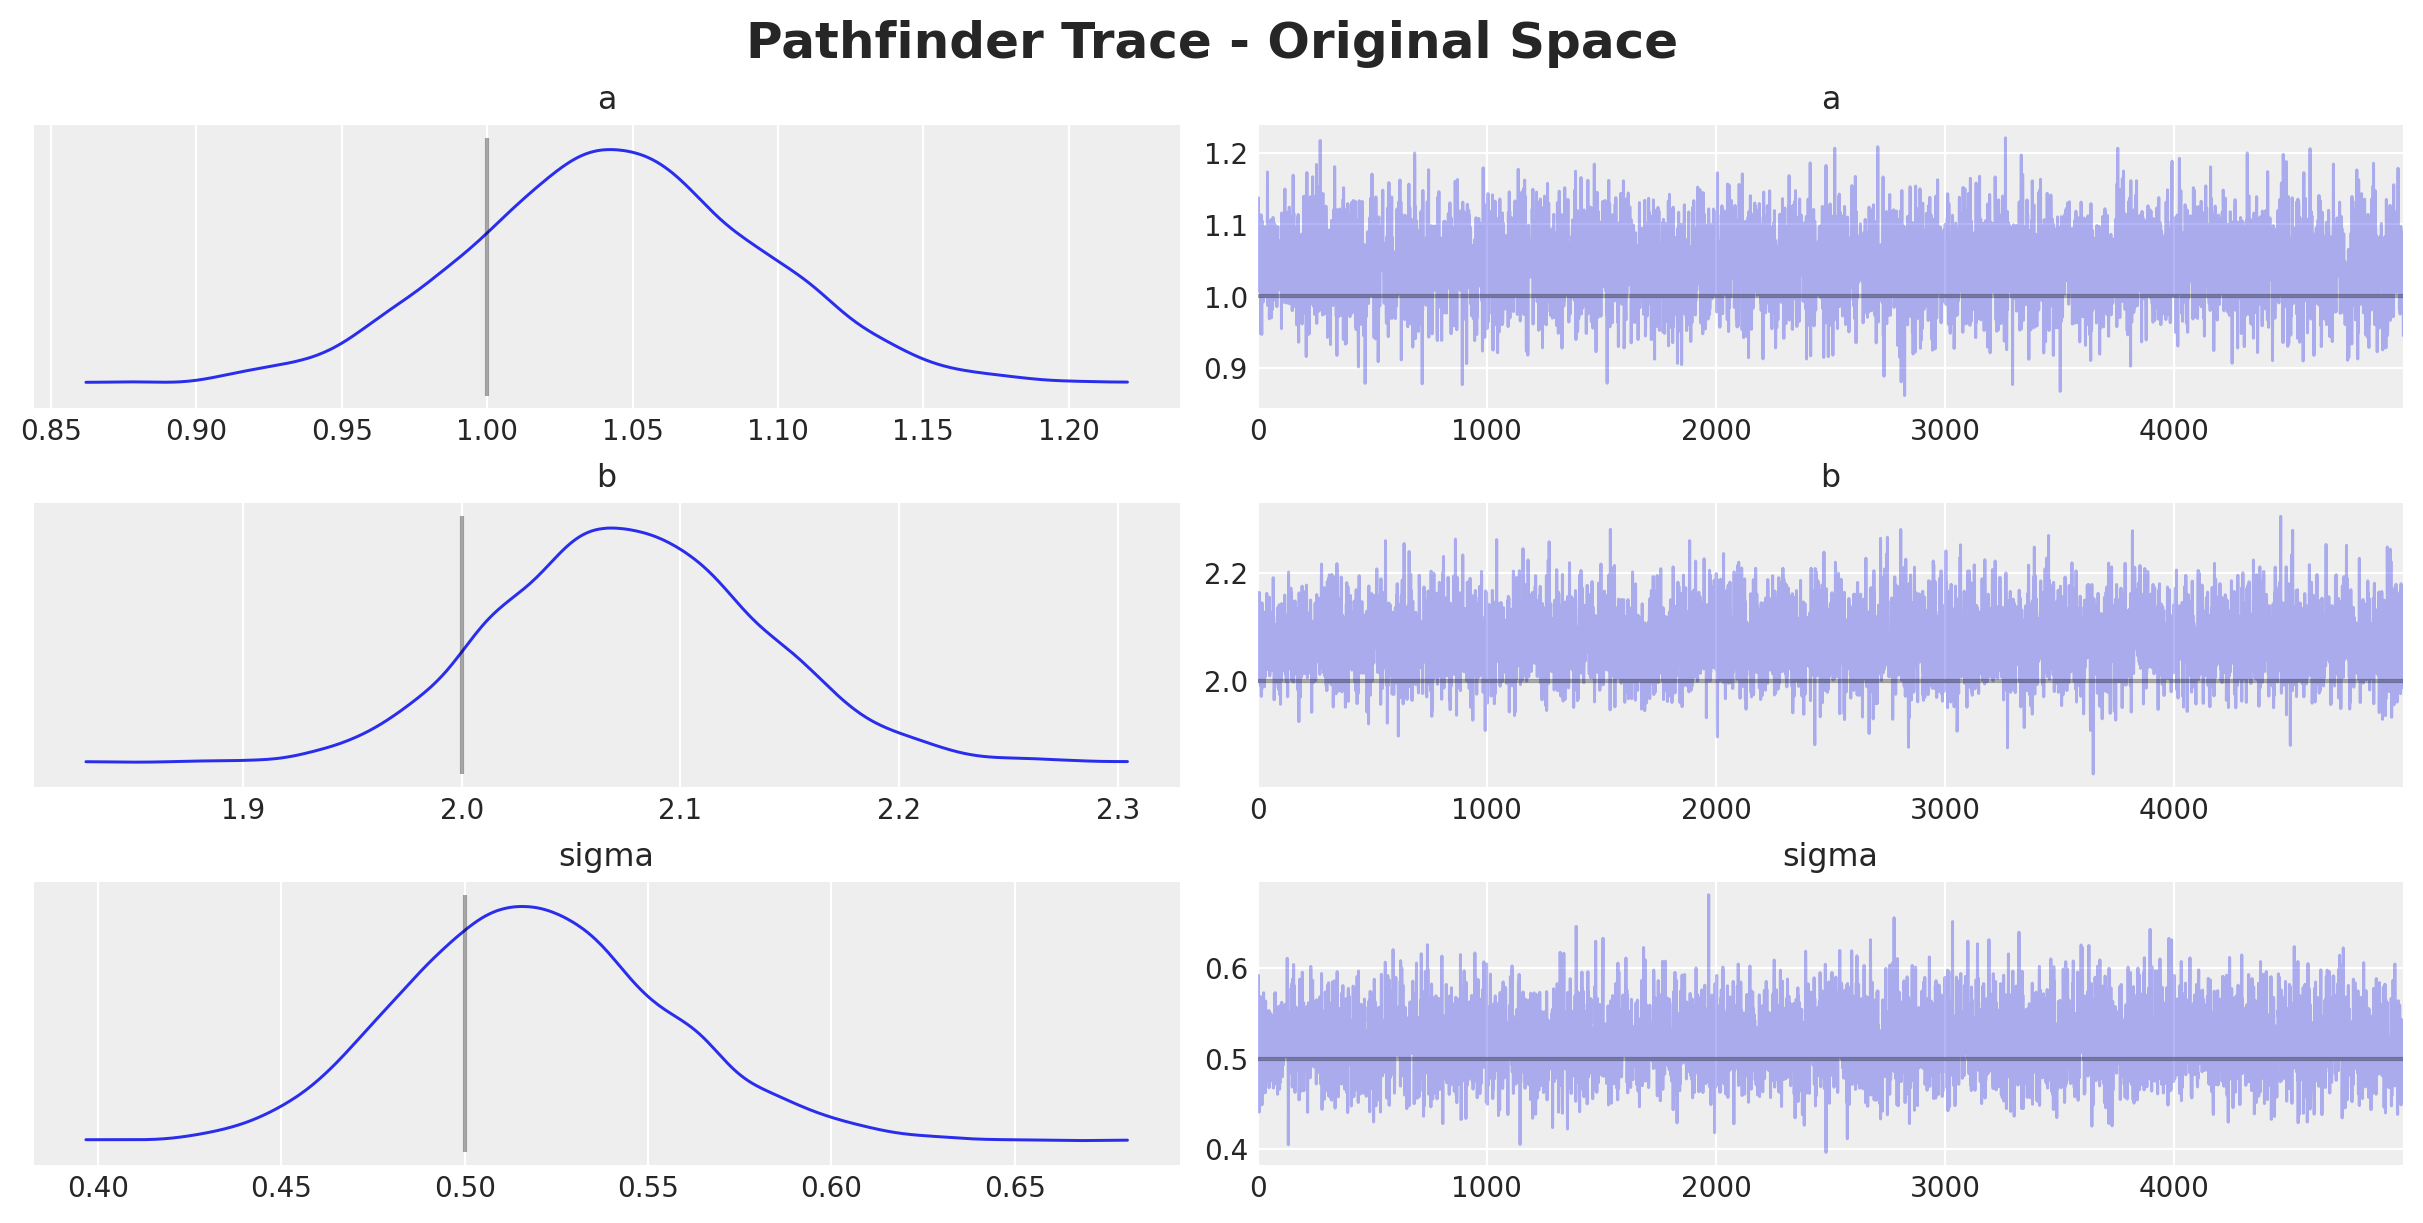

In [8]:
posterior_samples_transformed = jax.vmap(postprocess_fn(x, y))(posterior_samples)

rng_key, rng_subkey = random.split(rng_key)
posterior_predictive_samples_transformed = Predictive(
    model=model, posterior_samples=posterior_samples_transformed
)(rng_subkey, x)

idata_pathfinder_transformed = az.from_dict(
    posterior={
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in posterior_samples_transformed.items()
    },
    posterior_predictive={
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in posterior_predictive_samples_transformed.items()
    },
)

axes = az.plot_trace(
    data=idata_pathfinder_transformed,
    var_names=["~mu"],
    compact=True,
    lines=[
        ("a", {}, a),
        ("b", {}, b),
        ("sigma", {}, sigma),
    ],
    backend_kwargs={"layout": "constrained"},
)
plt.gcf().suptitle(
    t="Pathfinder Trace - Original Space", fontsize=18, fontweight="bold"
)

[Text(0.5, 0, 'x'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'Pathfinder Posterior Predictive')]

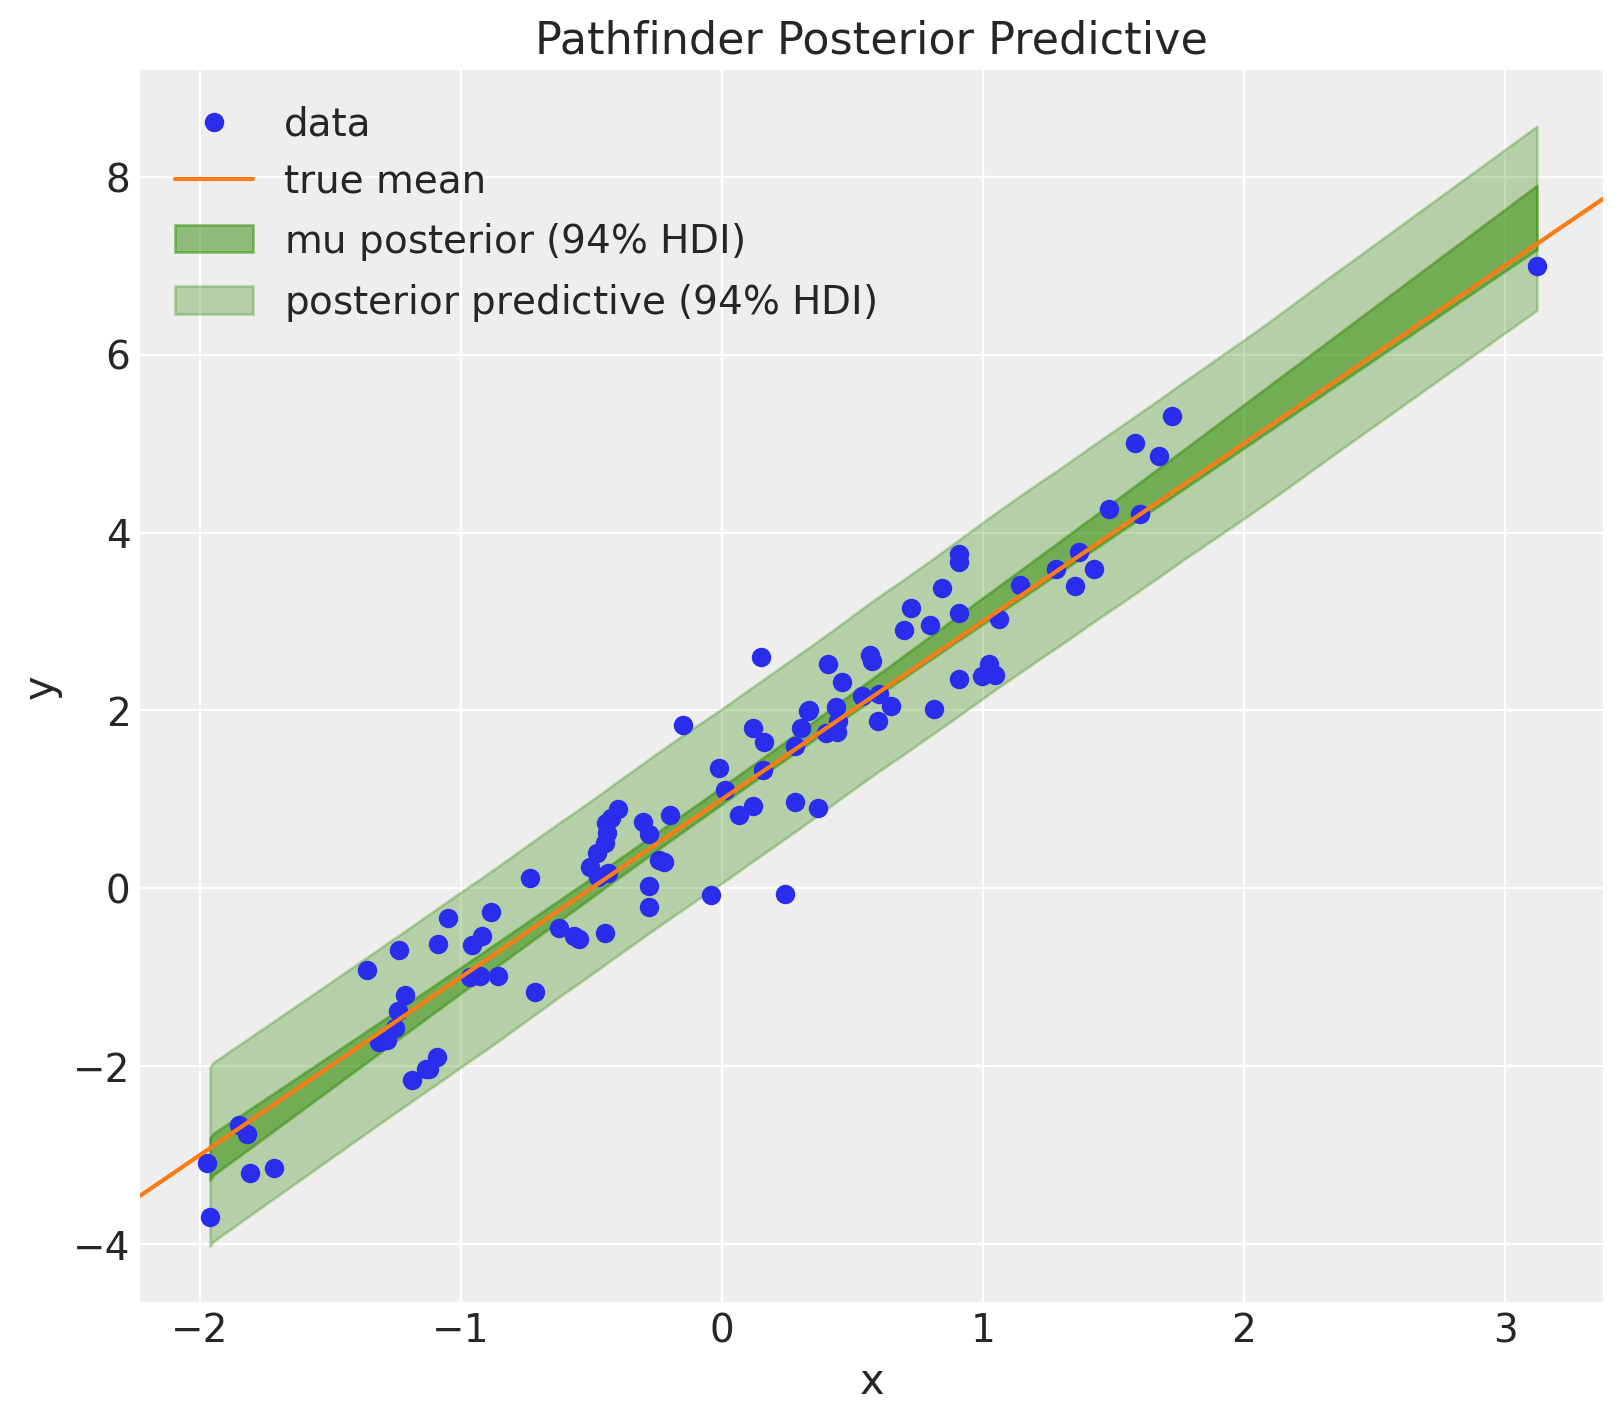

In [9]:
fig, ax = plt.subplots(figsize=(8, 7))
ax.plot(x, y, "o", c="C0", label="data")
ax.axline((0, a), slope=b, color="C1", label="true mean")
az.plot_hdi(
    x=x,
    y=idata_pathfinder_transformed["posterior_predictive"]["mu"],
    color="C2",
    fill_kwargs={"alpha": 0.5, "label": "mu posterior ($94\%$ HDI)"},
    ax=ax,
)
az.plot_hdi(
    x=x,
    y=idata_pathfinder_transformed["posterior_predictive"]["likelihood"],
    color="C2",
    fill_kwargs={"alpha": 0.3, "label": "posterior predictive ($94\%$ HDI)"},
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(xlabel="x", ylabel="y", title="Pathfinder Posterior Predictive")

## Appendix: SVI

Here we compare against the stochastic variational inference (SVI) algorithm implemented in `numpyro`.

In [10]:
guide = AutoMultivariateNormal(model=model)
optimizer = numpyro.optim.Adam(step_size=0.01)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
rng_key, rng_subkey = random.split(key=rng_key)
n_samples = 1_000
svi_result = svi.run(rng_subkey, n_samples, x, y)

100%|██████████| 1000/1000 [00:00<00:00, 1052.64it/s, init loss: 231.0948, avg. loss [951-1000]: 86.4815]


Text(0.5, 1.0, 'ELBO loss')

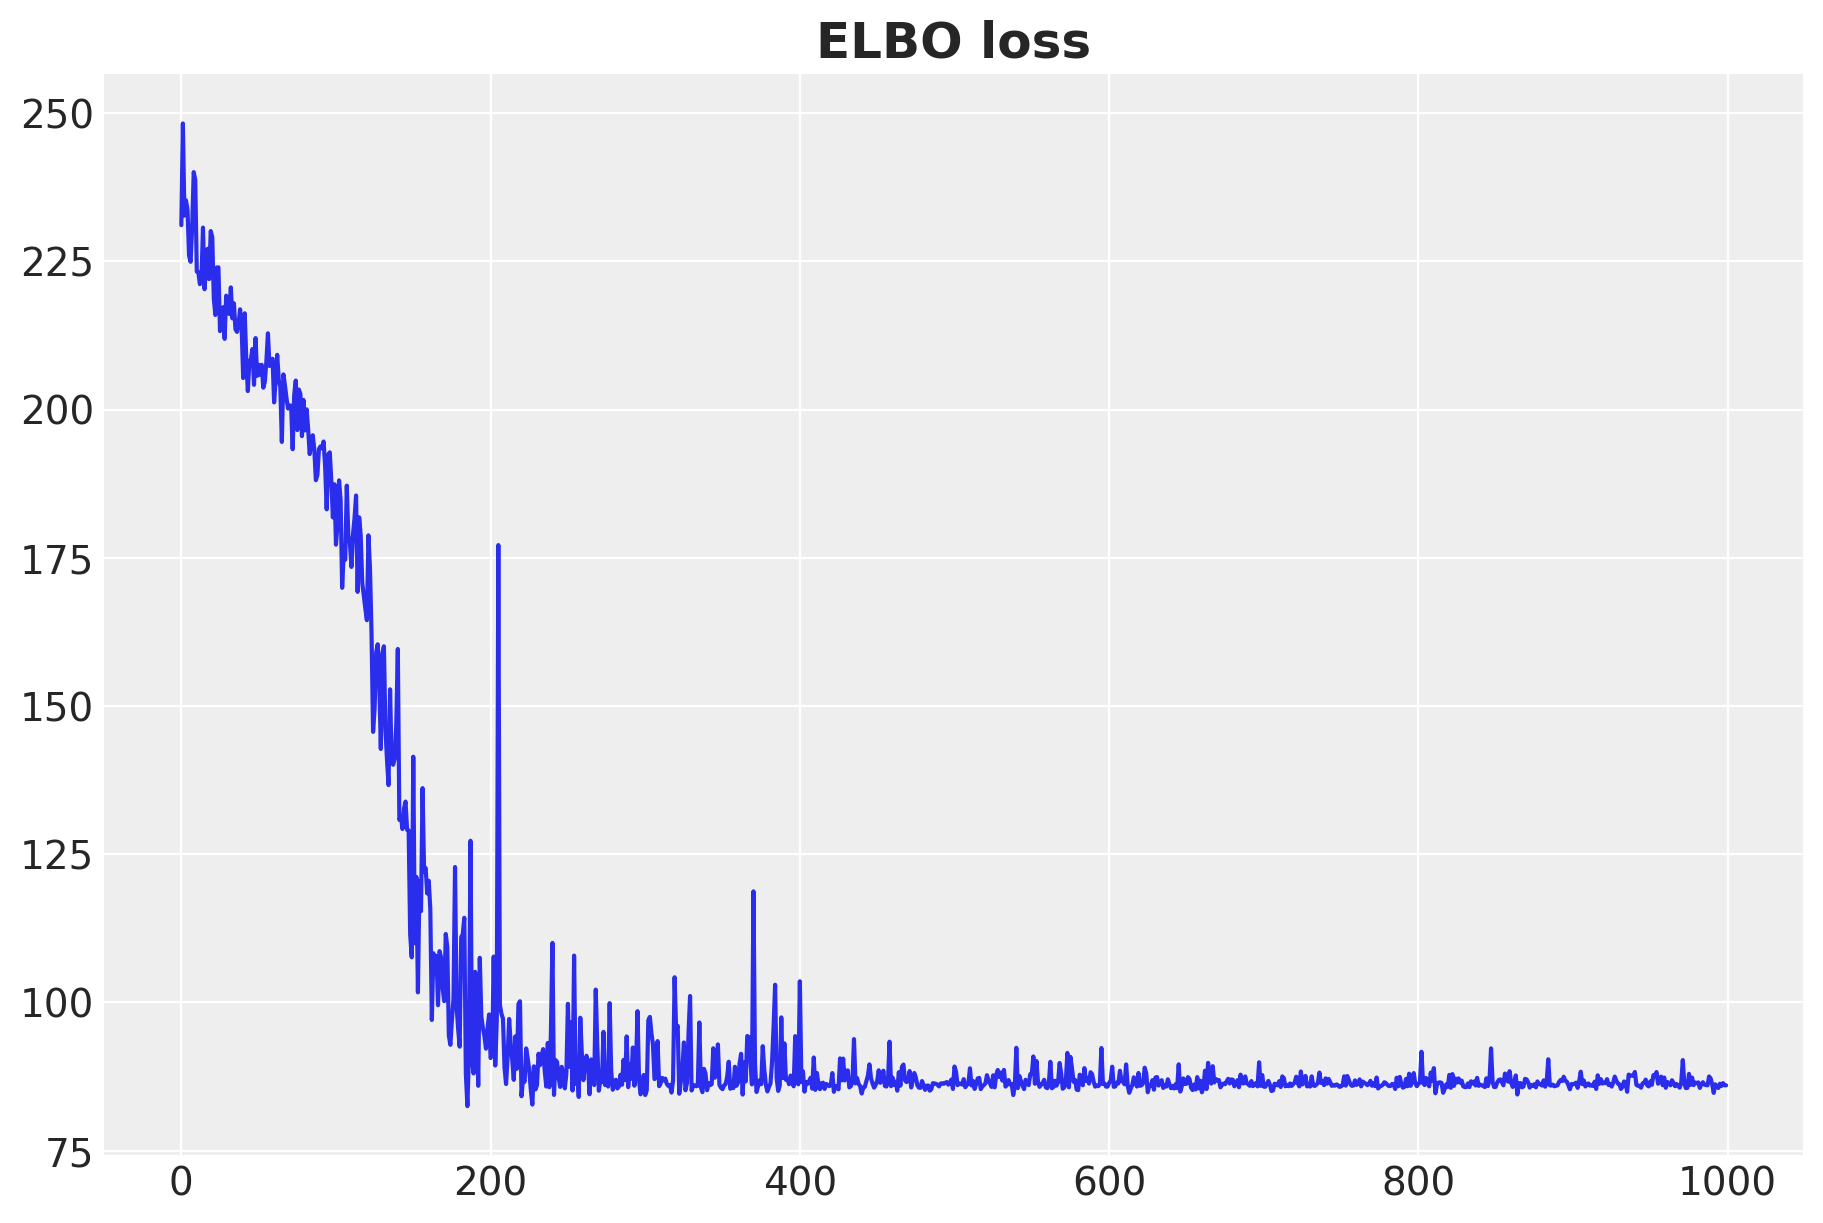

In [11]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(svi_result.losses)
ax.set_title("ELBO loss", fontsize=18, fontweight="bold")

In [12]:
params = svi_result.params
# get posterior samples (parameters)
predictive = Predictive(model=guide, params=params, num_samples=4_000)
rng_key, rng_subkey = random.split(key=rng_key)
posterior_samples = predictive(rng_subkey, x, y)
# get posterior predictive (deterministics and likelihood)
predictive = Predictive(model=model, guide=guide, params=params, num_samples=4_000)
rng_key, rng_subkey = random.split(key=rng_key)
samples = predictive(rng_subkey, x, y)

In [13]:
idata_svi = az.from_dict(
    posterior={
        k: np.expand_dims(a=np.asarray(v), axis=0) for k, v in posterior_samples.items()
    },
)

In [14]:
az.summary(data=idata_svi, var_names=["a", "b", "sigma"], round_to=3)

arviz - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.034,0.052,0.935,1.132,0.001,0.001,3158.147,3521.286,NaN
b,2.062,0.063,1.940,2.178,0.001,0.001,4074.610,3881.514,NaN
sigma,0.516,0.035,0.455,0.583,0.001,0.000,3630.886,3446.498,NaN


Text(0.5, 0.98, 'SVI Trace')

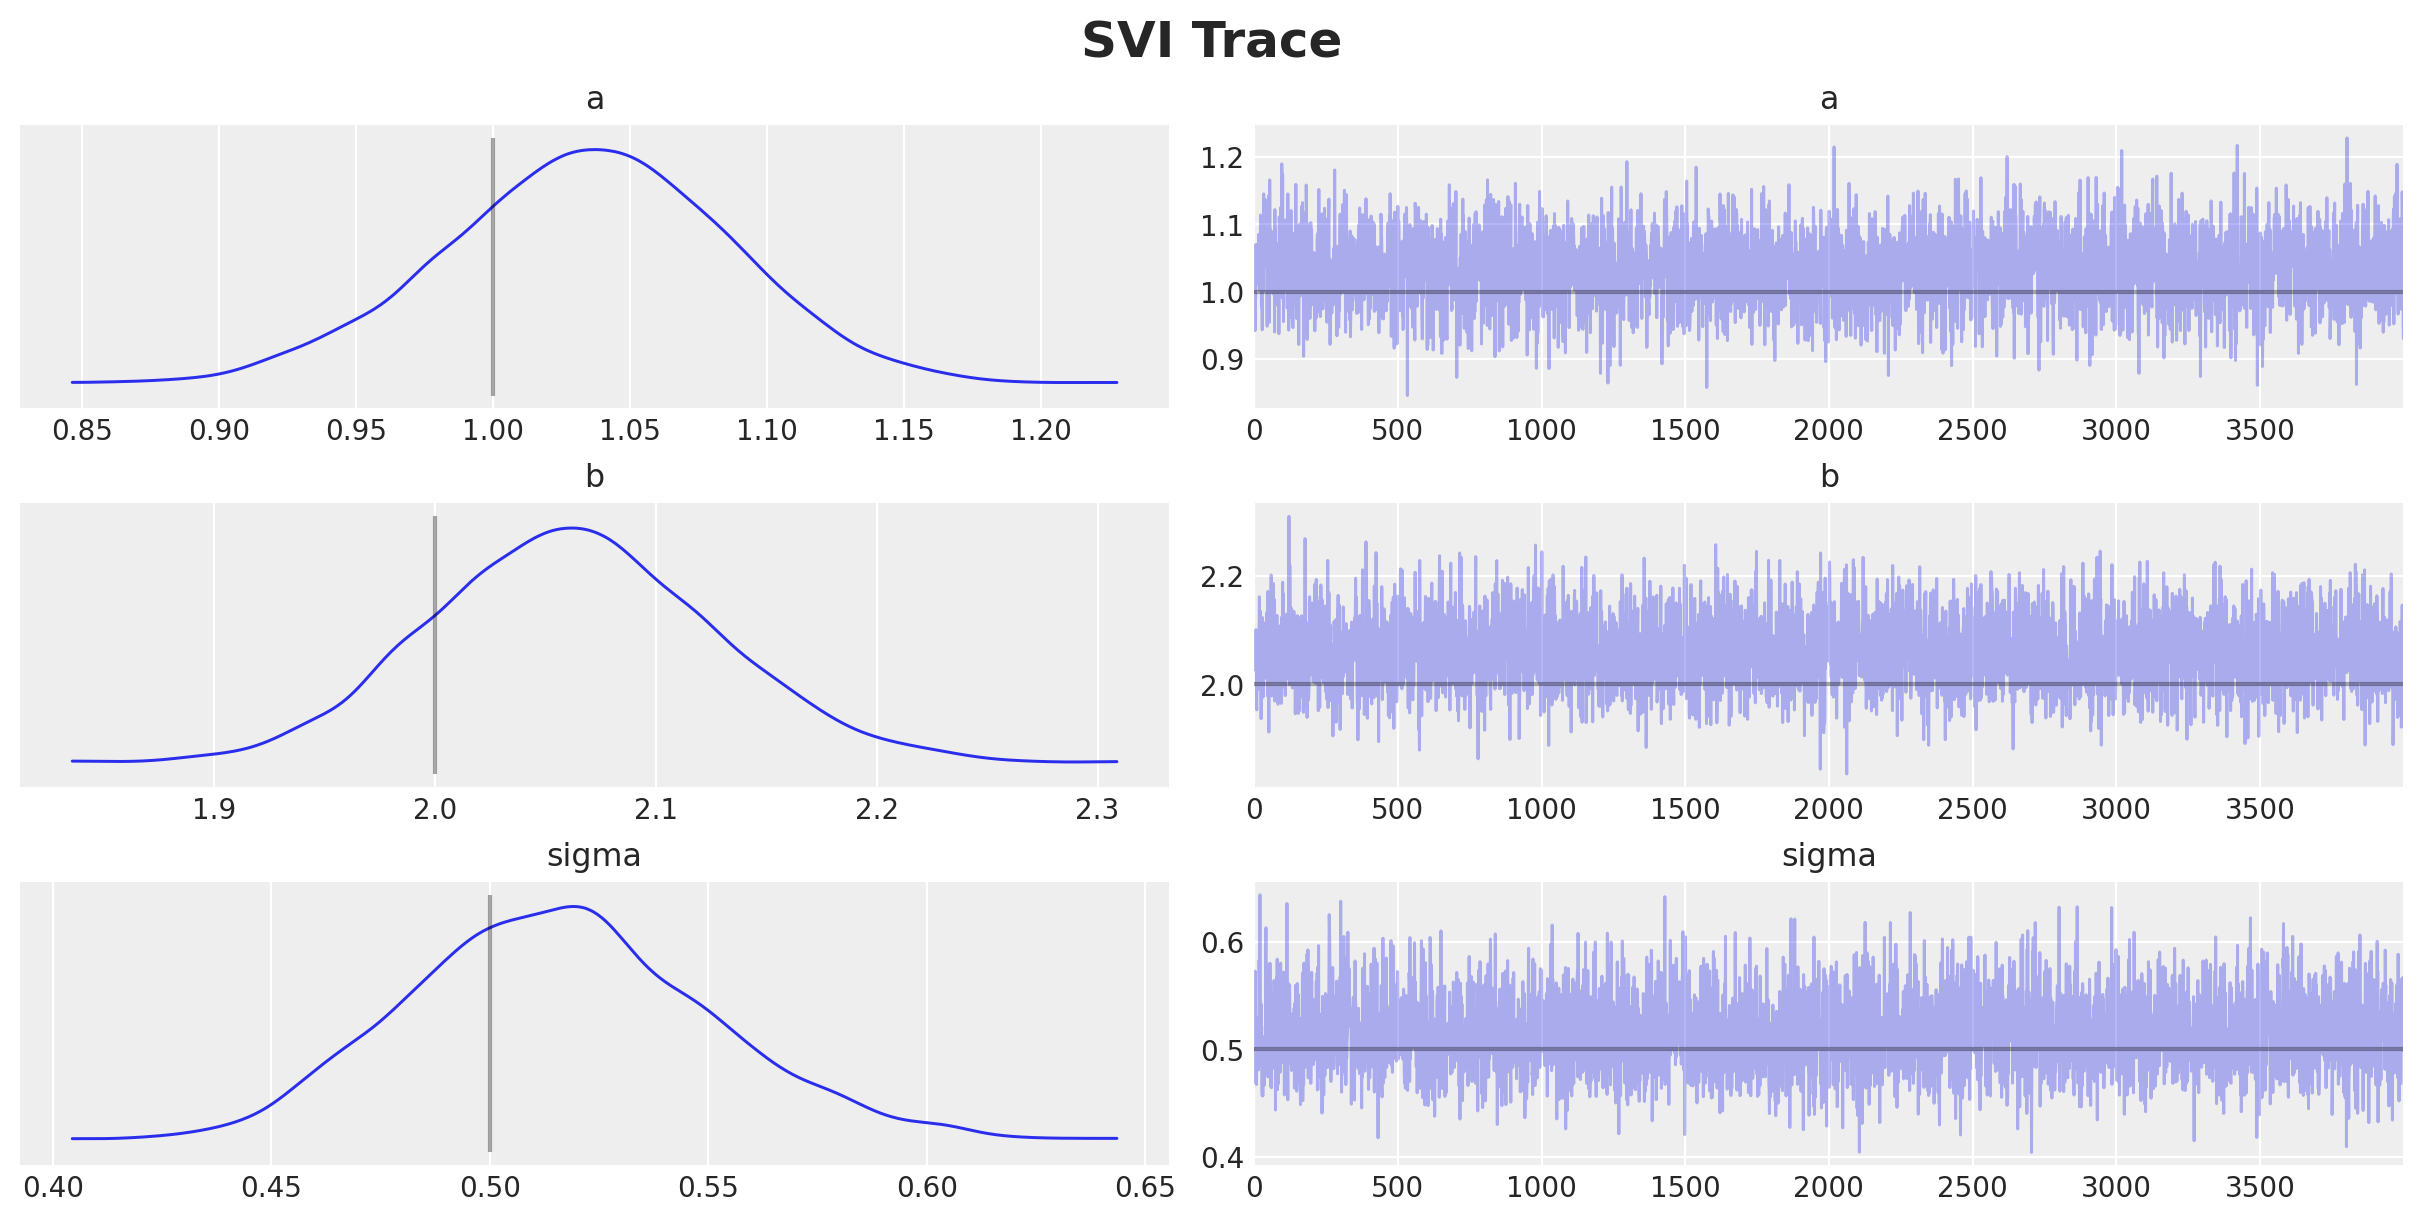

In [15]:
axes = az.plot_trace(
    data=idata_svi,
    var_names=["a", "b", "sigma"],
    compact=True,
    lines=[
        ("a", {}, a),
        ("b", {}, b),
        ("sigma", {}, sigma),
    ],
    backend_kwargs={"layout": "constrained"},
)
plt.gcf().suptitle(t="SVI Trace", fontsize=18, fontweight="bold")

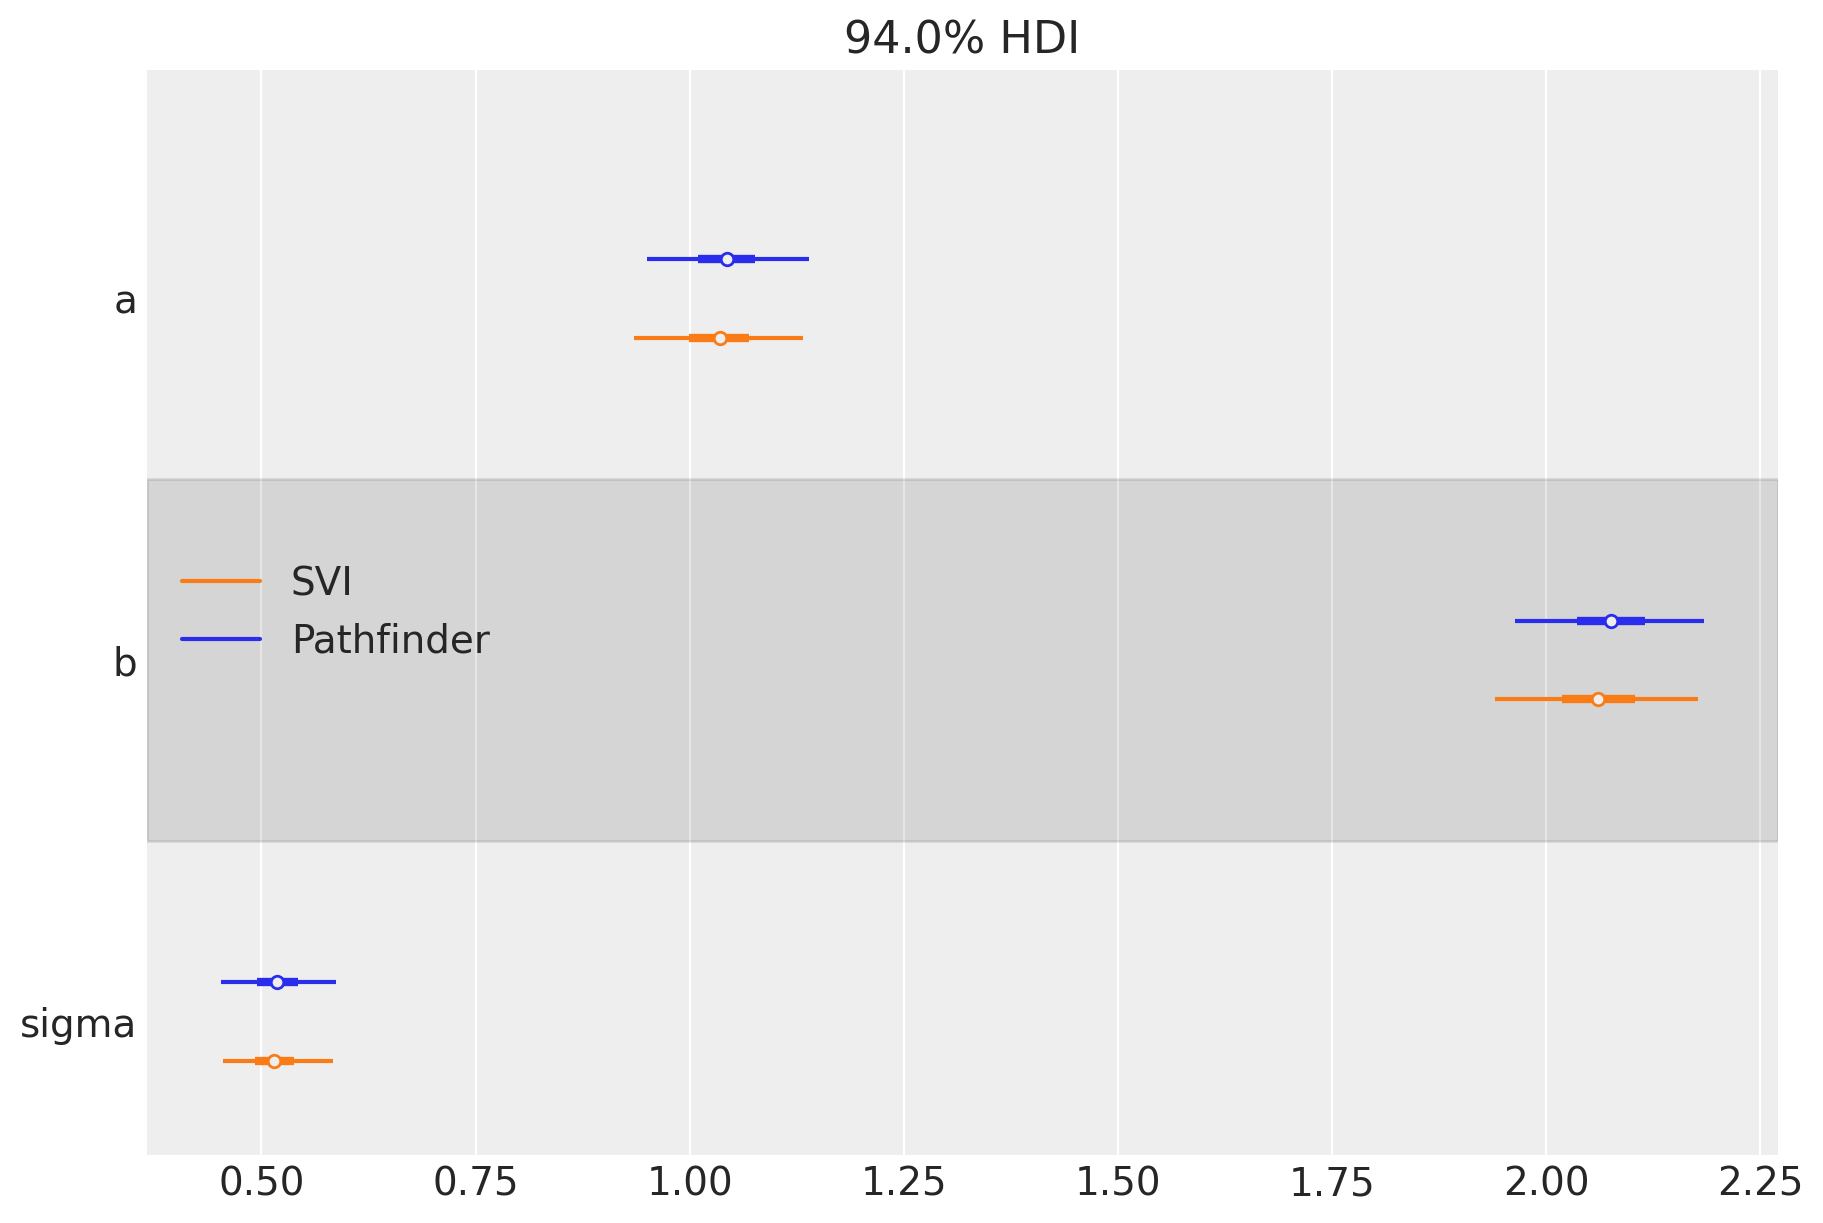

In [16]:
axes = az.plot_forest(
    data=[idata_pathfinder_transformed, idata_svi],
    model_names=["Pathfinder", "SVI"],
    var_names=["a", "b", "sigma"],
    combined=True,
    figsize=(9, 6),
)